# Init

In [1]:
# List of tickers for Korean stocks
tickers = {
    "삼성전자": "005930", "SK": "034730", "한화": "000880",
    "두산": "000150", "기아": "000270", "현대차": "005380",
    "LG": "003550", "NAVER": "035420", "카카오": "035720", "롯데지주": "004990"
}

# Date range for the stock data
start_date = "20200101"
end_date = "20250101"

In [2]:
# Target ticker for analysis
# TARGET_TICKER = "삼성전자"
TARGET_TICKER = list(tickers.keys())[0]
ticker_code = tickers[TARGET_TICKER]
TARGET_TICKER, ticker_code, start_date, end_date

('삼성전자', '005930', '20200101', '20250101')

In [3]:
import numpy as np
import torch

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

In [4]:
# Load the train, val, and test sets (list of DataFrames) from parquet files
import os
import json
import pandas as pd

dataset_dir = f"{ticker_code}_dataset"
train = []
val = []
test = []

if os.path.exists(dataset_dir):
    print(f"Loading dataset from {dataset_dir}/ directory...")
    
    # Load metadata
    with open(f"{dataset_dir}/metadata.json", 'r') as f:
        metadata = json.load(f)
    
    SEQ_LENGTH = metadata["seq_length"]
    print(f"Sequence length: {SEQ_LENGTH}")
    print(f"Ticker: {metadata['target_ticker']} ({metadata['ticker_code']})")
    assert SEQ_LENGTH > 0, "Sequence length must be greater than 0"
    assert ticker_code == metadata['ticker_code'], "Ticker code mismatch in metadata"
    assert TARGET_TICKER == metadata['target_ticker'], "Target ticker mismatch in metadata"
    
    # Load and reconstruct train set
    train_combined = pd.read_parquet(f"{dataset_dir}/train.parquet")
    for window_id in range(metadata["train_windows"]):
        window_df = train_combined[train_combined['window_id'] == window_id].drop('window_id', axis=1).reset_index(drop=True)
        train.append(window_df)
    
    # Load and reconstruct validation set
    val_combined = pd.read_parquet(f"{dataset_dir}/val.parquet")
    for window_id in range(metadata["val_windows"]):
        window_df = val_combined[val_combined['window_id'] == window_id].drop('window_id', axis=1).reset_index(drop=True)
        val.append(window_df)
    
    # Load and reconstruct test set
    test_combined = pd.read_parquet(f"{dataset_dir}/test.parquet")
    for window_id in range(metadata["test_windows"]):
        window_df = test_combined[test_combined['window_id'] == window_id].drop('window_id', axis=1).reset_index(drop=True)
        test.append(window_df)
    
    print(f"Loaded - Train windows: {len(train)}, Val windows: {len(val)}, Test windows: {len(test)}")
    print("Dataset loaded successfully!")
else:
    print(f"Dataset directory {dataset_dir} not found. Please run the dataset creation cells first.")


Loading dataset from 005930_dataset/ directory...
Sequence length: 20
Ticker: 삼성전자 (005930)
Loaded - Train windows: 947, Val windows: 119, Test windows: 103
Dataset loaded successfully!


In [5]:
FORECAST_LENGTH = 5
val_list = []

for val_df in val:
    last_target = val_df["target"].iloc[-1]

    # Make prompt with the val_df
    datas = val_df.drop(columns=["target"]).to_dict(orient='records')
    datas_str = ""
    for data in datas:
        datas_str += str(data["date"]).split(" ")[0] + "\t"
        for i, (k, v) in enumerate(data.items()):
            # v = round(v, 2) if isinstance(v, (int, float)) else str(v)
            data[k] = round(v, 2) if isinstance(v, (int, float)) else str(v)
        datas_str += "\t".join([f"{k}: {str(v).replace('\n', '')}" for k, v in data.items() if k != "date"]) + "\n"
    datas_str = datas_str.strip()
    prompt_str = f"""Here is the Stock data of {TARGET_TICKER} ({ticker_code}) for the past {SEQ_LENGTH} days:
I will now give you data for the past {SEQ_LENGTH} recorded dates, and please help me forecast the data for next {FORECAST_LENGTH} recorded dates. The data is as follows:
```
{datas_str}
```
Please give me the close data for the next {FORECAST_LENGTH} recorded dates, remember to give me the close data. 
You must first conduct reasoning inside <think> …</think>. 
When you have the final answer, you can output the answer inside <answer>…</answer> and the reason of the answer inside <reason>…</reason>.

Example output:
```
<think>...</think>
<answer>20XX-XX-XX\tclose: XXXXX
20XX-XX-XX\tclose: XXXXX
... (continue for {FORECAST_LENGTH} days)</answer>
<reason>...</reason>
```
"""

    val_list.append({
        "prompt": prompt_str,
        "target": int(last_target),
    })

# Convert to DataFrame
val_combined = pd.DataFrame(val_list)
val_combined

,prompt,target
0,Here is the Stock data of 삼성전자 (005930) for th...,77000
1,Here is the Stock data of 삼성전자 (005930) for th...,76600
2,Here is the Stock data of 삼성전자 (005930) for th...,76600
3,Here is the Stock data of 삼성전자 (005930) for th...,76500
4,Here is the Stock data of 삼성전자 (005930) for th...,74700
...,...,...
114,Here is the Stock data of 삼성전자 (005930) for th...,80000
115,Here is the Stock data of 삼성전자 (005930) for th...,80600
116,Here is the Stock data of 삼성전자 (005930) for th...,80800
117,Here is the Stock data of 삼성전자 (005930) for th...,81300


In [ ]:
from openai import OpenAI
client = OpenAI(
  base_url="https://openrouter.ai/api/v1",
  api_key="sk-or-v1-CENSORED"  # Replace with your actual API key,
)
MODEL="google/gemini-2.5-flash"
# MODEL="tngtech/deepseek-r1t2-chimera:free"

In [12]:
import re 

def get_forecast(prompt, model):
    completion = client.chat.completions.create(
      model=model,
      messages=[
        {
          "role": "user",
          "content": prompt
        }
      ],
      reasoning_effort="high",
    )
    result = str(completion.choices[0].message.content)
    # Extract the <reason>...</reason> content
    reason_match = re.search(r'<reason>(.*?)</reason>', result, re.DOTALL)
    if not reason_match:
        raise ValueError(f"No valid <reason> section found in the response: {result}")
    reason_content = reason_match.group(1).strip()
    
    # Extract <answer>...</answer> content
    answer_pattern = r'<answer>(.*?)</answer>'
    answer_match = re.search(answer_pattern, result, re.DOTALL)
    if not answer_match:
        raise ValueError(f"No valid <answer> section found in the response: {result}")
    
    answer = answer_match.group(1).strip()
    lines = answer.split('\n')
    forecast = {}
    for line in lines:
        parts = line.split('\t')
        if len(parts) >= 2:
            date = parts[0].strip()
            close_value = parts[1].split(':')[1].strip().replace(',', '')
            forecast[date] = float(close_value)

    return reason_content, forecast

In [13]:
import time
from threading import Thread, Lock
from queue import Queue, Empty

def get_forecast_multithread(prompts, model, num_threads=8):
    # TODO: Implement multithreading to handle multiple prompts and models
    result_list = []
    result_dict = {}
    queue = Queue()
    lock = Lock()
    count = 0
    
    def worker(index, prompt, model):
        nonlocal count
        try:
            result = get_forecast(prompt, model)
        except Exception as e:
            print(f"Error processing prompt {index}: {e}")
            result = ("Error", {})
        queue.put((index, result))
        with lock:
            count -= 1
    
    last = time.time()
    for index, prompt in enumerate(prompts):
        while count >= num_threads:
            try:
                get_index, forecast_result = queue.get_nowait()
                result_dict[get_index] = forecast_result
            except Empty:
                time.sleep(0.1)
        thread = Thread(target=worker, args=(index, prompt, model, ))
        thread.start()
        with lock:
            count += 1
        if time.time() - last > 1:
            print(f"Processing: {len(result_dict)}/{len(prompts)} (thread: {count}/{num_threads})", end='\r')
            last = time.time()
        
    last = time.time()
    while count > 0:
        get_index, forecast_result = queue.get()
        result_dict[get_index] = forecast_result
        if time.time() - last > 1:
            print(f"Processing: {len(result_dict)}/{len(prompts)} (thread: {count}/{num_threads})", end='\r')
            last = time.time()

    keys = sorted(result_dict.keys())
    for key in keys:
        result_list.append(result_dict[key])
    
    if len(result_dict) != len(prompts):
        raise ValueError(f"News data count mismatch: {len(result_dict)} vs {len(prompts)}")
    
    print(f"Processing complete: {len(result_list)}/{len(prompts)}" + " "*30, end='\r')

    return result_list

In [14]:
results = get_forecast_multithread(val_combined["prompt"].values, MODEL, num_threads=32)
results[:10]

[("Based on the provided 20 days of data for Samsung Electronics (005930), the following observations and rationale inform the forecast:\n\n1.  **Strong Uptrend:** The stock has been in a clear and consistent uptrend since mid-December, especially from December 20th onwards, showing significant daily gains. The last recorded closing price on 2024-01-02 was 79600, just shy of the psychological 80,000 KRW mark.\n2.  **Bullish Technical Indicators:**\n    *   **MACD:** The Moving Average Convergence Divergence (MACD) line crossed above its signal line on December 20th and has since shown a strong and widening upward divergence, indicating robust bullish momentum.\n    *   **RSI:** The Relative Strength Index (RSI) is in overbought territory (around 80.9 on 2024-01-02). While this suggests a potential for pullback, in strong trending markets, the price can remain elevated for extended periods even with high RSI.\n    *   **Bollinger Bands:** The price is hugging or slightly exceeding the u

In [15]:
for i, result in enumerate(results):
    _, forecast = result
    if forecast == {}:
        print(f"Result {i}: No forecast available")
        prompt = val_combined.iloc[i]["prompt"]
        result = get_forecast(prompt, MODEL)
        results[i] = result
        print(f"Result {i} updated with new forecast: {result[1]}")

In [17]:
# Save results
import json
results_file = f"{dataset_dir}/results.json"
with open(results_file, 'w') as f:
    json.dump(results, f, indent=4, ensure_ascii=False)

In [18]:
target_forecasts = []
for result in results:
    _, forecast = result[0], result[1]
    target_forecasts.append(list(forecast.values())[0])
len(target_forecasts), len(val_combined["target"].values)

(119, 119)

In [46]:
# GET MSE, RMSE, MAE
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error

forecast = target_forecasts
ground_truth = list(val_combined["target"].values)
mse = mean_squared_error(ground_truth, forecast)
rmse = root_mean_squared_error(ground_truth, forecast)
mae = mean_absolute_error(ground_truth, forecast)
print(f"MSE: {mse}, RMSE: {rmse}, MAE: {mae}")

MSE: 1928361.344537815, RMSE: 1388.6545087017919, MAE: 1097.4789915966387


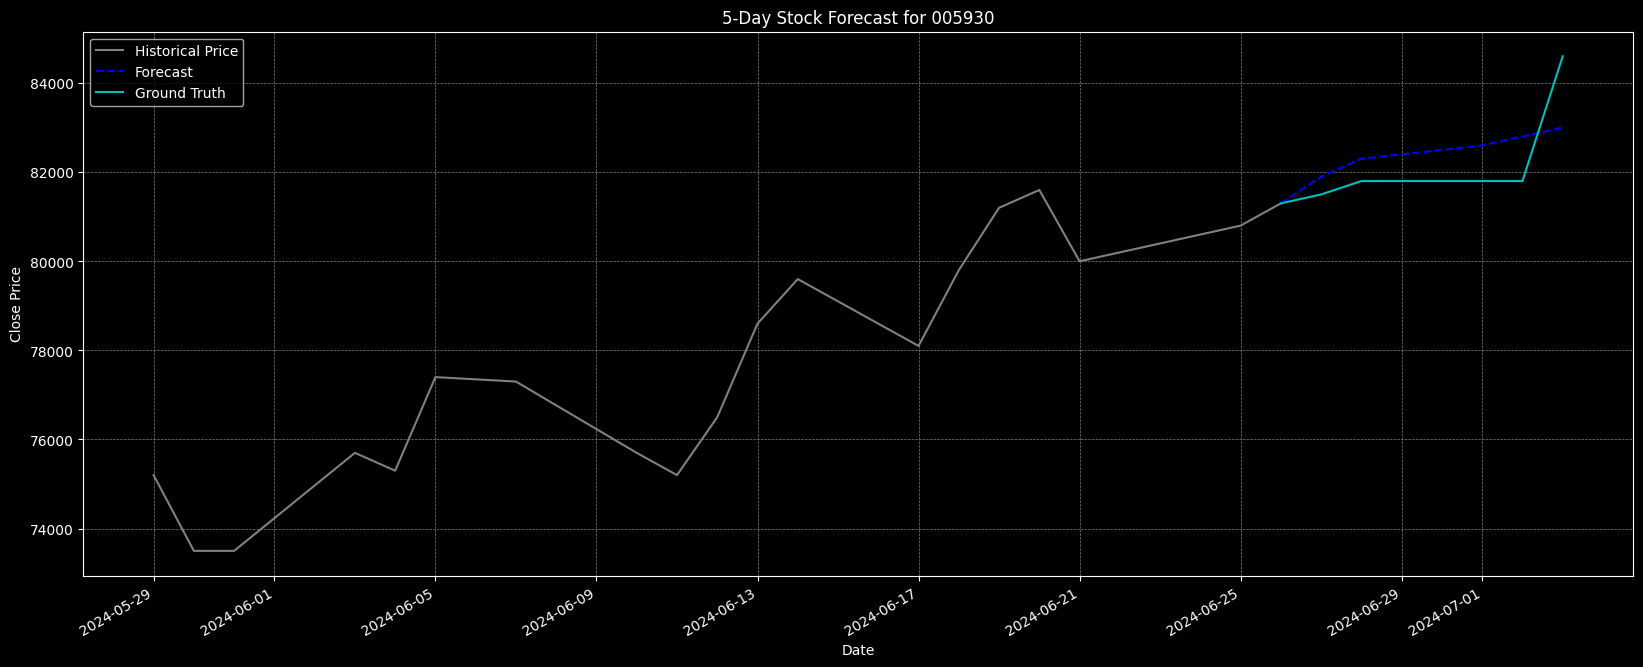

In [44]:
import matplotlib.pyplot as plt
import pandas as pd

# -------------------------------------------------------------------
# 1. 마지막 검증 데이터로 5일치 예측 생성
# -------------------------------------------------------------------
# val 데이터셋의 마지막 윈도우(과거 20일 데이터)를 프롬프트로 사용
last_val_window_prompt = val_combined["prompt"].values[-1]
# 해당 프롬프트로 5일치 예측 생성
reasoning, forecast_data = get_forecast(last_val_window_prompt, MODEL)

# 예측된 날짜와 가격을 리스트로 변환
forecast_dates = list(forecast_data.keys())
forecast_prices = list(forecast_data.values())

# -------------------------------------------------------------------
# 2. 예측에 대한 실제 값(Ground Truth) 준비
# -------------------------------------------------------------------
# 예측 기간에 해당하는 실제 데이터는 test_df의 앞부분에 위치함
ground_truth_df = test[0].iloc[:len(forecast_dates)]
ground_truth_prices = ground_truth_df['close'].values

# -------------------------------------------------------------------
# 3. 시각화
# -------------------------------------------------------------------
# 예측에 사용된 과거 데이터(20일)
history_df = val[-1]

# 그래프 전체에 사용할 날짜 인덱스 생성 (과거 데이터 + 예측 데이터)
combined_dates = list(history_df['date']) + [pd.to_datetime(d) for d in forecast_dates]

# 그래프 크기 및 스타일 설정
plt.style.use('dark_background')
plt.figure(figsize=(20, 8))

# 1) 과거 실제 주가 (History)
plt.plot(combined_dates[:-5], history_df['close'], 'gray', label='Historical Price')

# 2) 예측된 5일 주가 (Forecast)
# 과거 마지막 날과 예측 첫날을 이어주기 위해 과거 마지막 종가 추가
plt.plot(combined_dates[-6:], [history_df['close'].iloc[-1]] + forecast_prices, 'b--', label='Forecast')

# 3) 실제 5일 주가 (Ground Truth)
# 과거 마지막 날과 실제 첫날을 이어주기 위해 과거 마지막 종가 추가
plt.plot(combined_dates[-6:], [history_df['close'].iloc[-1]] + list(ground_truth_prices), 'c-', label='Ground Truth')


# 그래프 제목 및 레이블 설정
plt.title(f'5-Day Stock Forecast for {ticker_code}')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(color='gray', linestyle='--', linewidth=0.5)

# x축 날짜 포맷 설정
plt.gcf().autofmt_xdate()

plt.show()